In [1]:
! pip install kaggle

from google.colab import drive
drive.mount('/content/drive')

! cp /content/drive/MyDrive/kaggle.json ~/
! mkdir ~/.kaggle
! mv ~/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [3]:
! kaggle datasets download -d eldarsultanow/polytopes-5d-normalized-reflexive
! unzip polytopes-5d-normalized-reflexive.zip

Dataset URL: https://www.kaggle.com/datasets/eldarsultanow/polytopes-5d-normalized-reflexive
License(s): unknown
polytopes-5d-normalized-reflexive.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  polytopes-5d-normalized-reflexive.zip
replace polytopes_5d_reflexive.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: polytopes_5d_reflexive.txt  


In [1]:
import sys
import numpy as np
import pandas as pd
import re
from ast import literal_eval
np.set_printoptions(threshold=sys.maxsize)

In [2]:
file_content = ''
with open('polytopes_5d_reflexive.txt', 'r') as file:
    file_content = file.read()

i = 0
lst_polys = []

for line in re.findall(r"^\[.*?\]$", file_content, flags=re.S | re.M):
  try:
    arr, *rest = literal_eval(line.replace("array", ""))
    U, S, Vh = np.linalg.svd(arr, full_matrices=True)
    lst_polys.append([str(arr), np.matrix.trace(U), np.matrix.trace(Vh)] + rest)
    i += 1
  except:
    print("omitting: {0}".format(line))
print("{0} polytopes collected".format(i))

omitting: [['0' '1' '1' '0' '2']
224272 polytopes collected


In [3]:
df = pd.DataFrame(lst_polys, columns=['matrix', 'traceU', 'traceVh', 'vol', 'h11', 'h12', 'h13', 'h22', 'chi', 'numptsM', 'numvertsM', 'numptsN', 'numvertsN'])

In [7]:
df.head()

,matrix,traceU,traceVh,vol,h11,h12,h13,h22,chi,numptsM,numvertsM,numptsN,numvertsN
0,"[[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0...",0.788875,0.137026,24,4,0,232,988,1464,10,8,246,12
1,"[[1, 0, 0, 0, 0], [-1, 0, 0, 0, 0], [0, 1, 0, ...",0.589976,-0.850823,28,4,0,244,1036,1536,10,8,260,13
2,"[[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0...",1.768890,-1.040558,36,4,0,171,744,1098,10,9,181,9
3,"[[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0...",1.178932,-1.421765,30,4,0,352,1468,2184,10,8,385,14
4,"[[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0...",0.942262,-1.471582,28,4,0,222,948,1404,10,8,238,13


In [4]:
df_sub = df.loc[:, df.columns != 'matrix']

In [9]:
df_sub.head()

,traceU,traceVh,vol,h11,h12,h13,h22,chi,numptsM,numvertsM,numptsN,numvertsN
0,0.788875,0.137026,24,4,0,232,988,1464,10,8,246,12
1,0.589976,-0.850823,28,4,0,244,1036,1536,10,8,260,13
2,1.768890,-1.040558,36,4,0,171,744,1098,10,9,181,9
3,1.178932,-1.421765,30,4,0,352,1468,2184,10,8,385,14
4,0.942262,-1.471582,28,4,0,222,948,1404,10,8,238,13


In [10]:
df.to_csv('polytopes_5d_reflexive.csv', index=True)

<Axes: xlabel='traceU', ylabel='traceVh'>

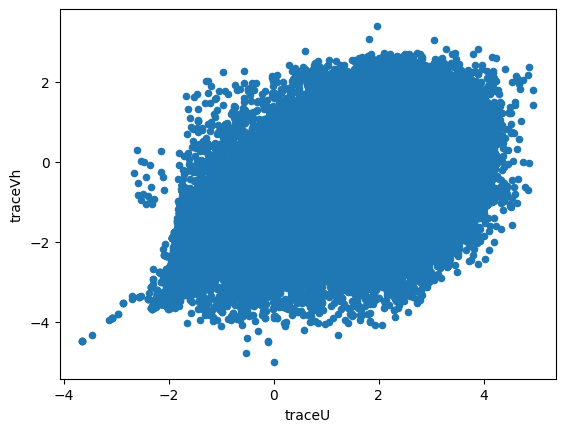

In [5]:
df.plot.scatter(x='traceU', y='traceVh')

In [6]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=5, min_samples=5).fit(df_sub)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = pd.DataFrame(db.labels_,columns=['Cluster ID'])
result = pd.concat((df_sub, labels), axis=1)
result.head()

,traceU,traceVh,vol,h11,h12,h13,h22,chi,numptsM,numvertsM,numptsN,numvertsN,Cluster ID
0,0.788875,0.137026,24,4,0,232,988,1464,10,8,246,12,0
1,0.589976,-0.850823,28,4,0,244,1036,1536,10,8,260,13,1
2,1.768890,-1.040558,36,4,0,171,744,1098,10,9,181,9,2
3,1.178932,-1.421765,30,4,0,352,1468,2184,10,8,385,14,3
4,0.942262,-1.471582,28,4,0,222,948,1404,10,8,238,13,4


<Axes: xlabel='traceU', ylabel='chi'>

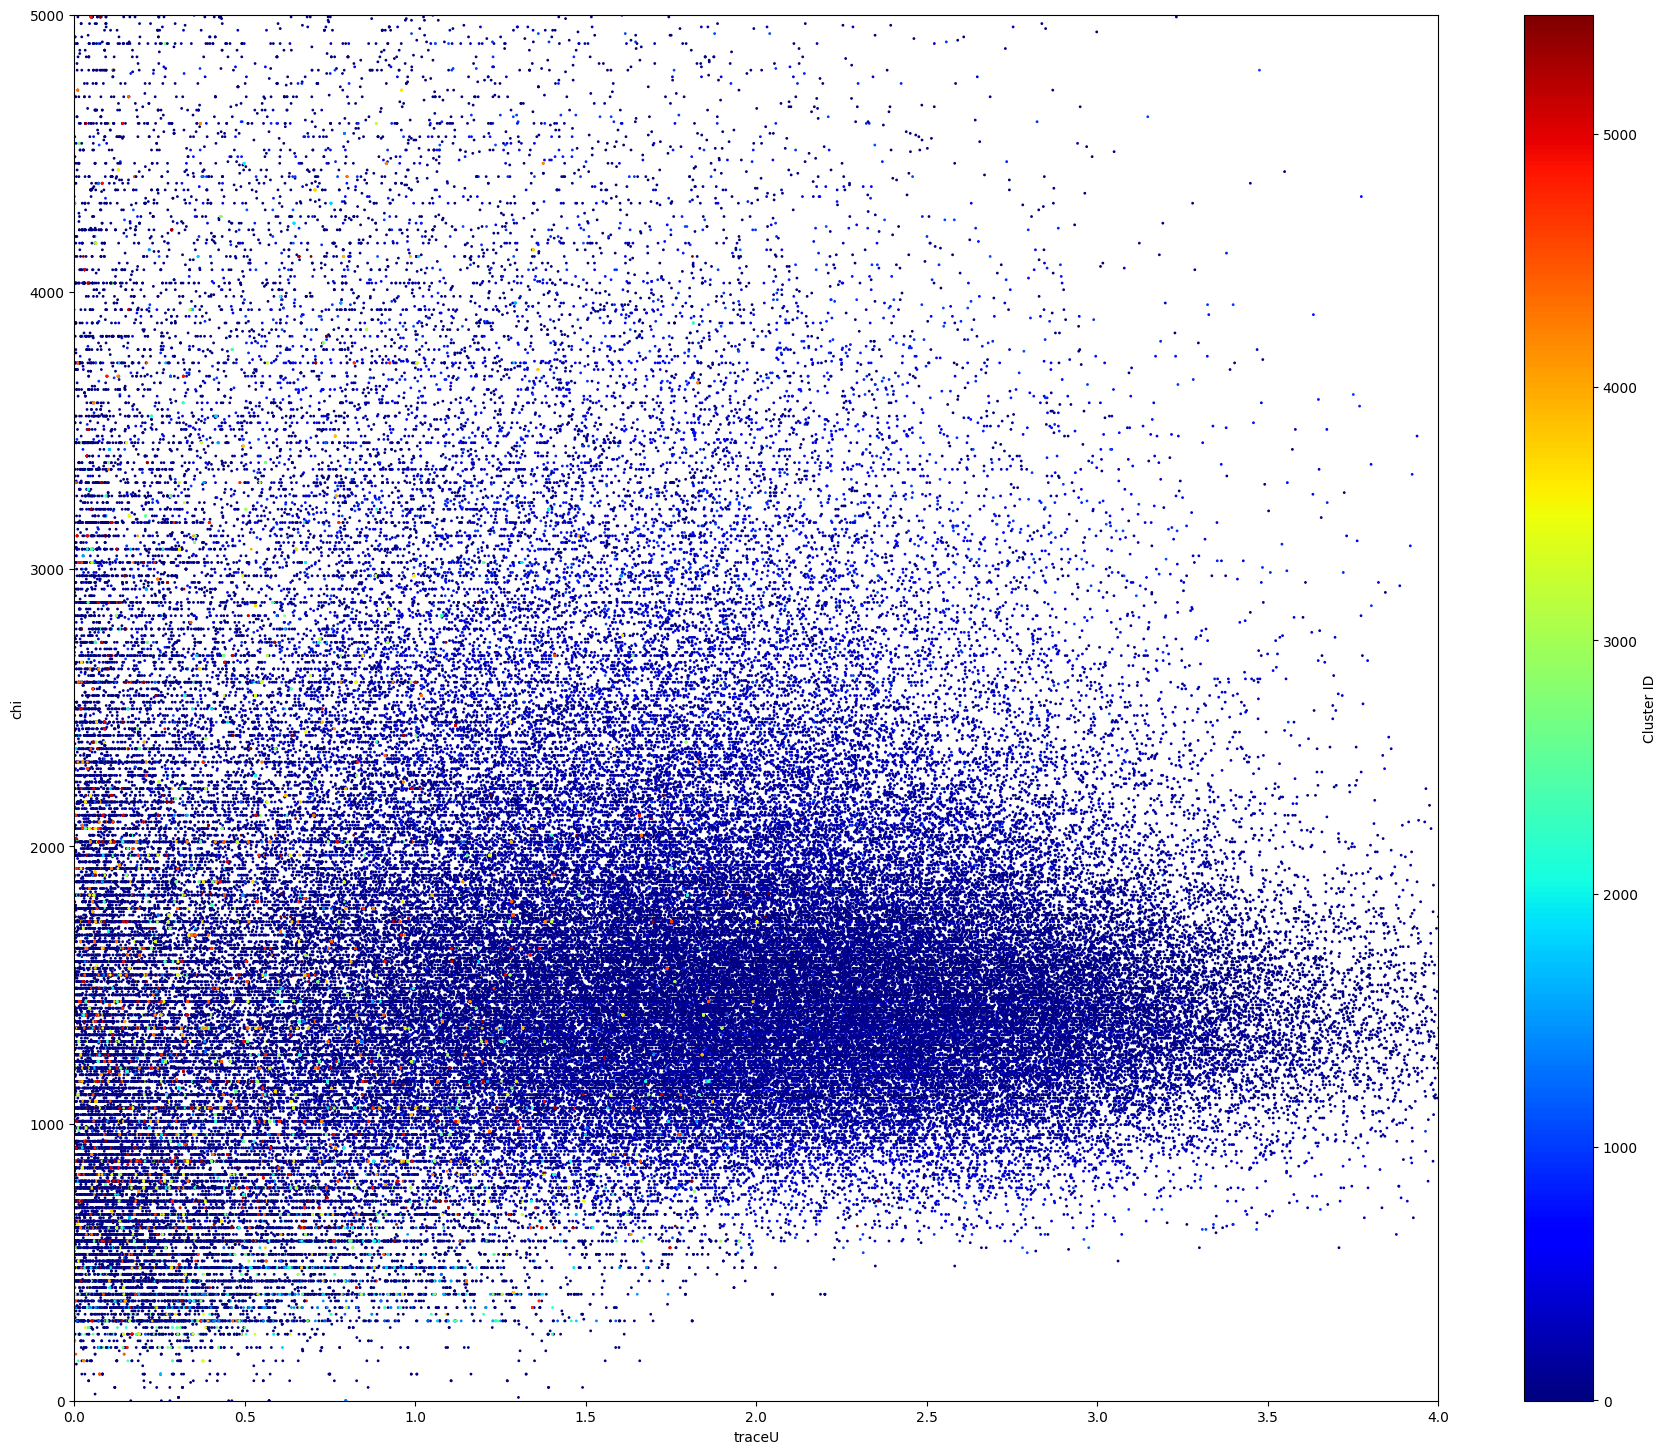

In [7]:
result.plot.scatter(figsize=(22,18), x='traceU', y='chi', xlim=(0,4), ylim=(0,5000), c='Cluster ID', s=1, colormap='jet')

In [61]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [11]:
!pip install hdbscan
import hdbscan

Find important features

In [10]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_sub)

model = KMeans(n_clusters=4, init = "k-means++", max_iter = 300, n_init = 10, random_state=42)
df_sub['cluster'] = model.fit_predict(df_scaled)

# Filter out noise points
df_filtered = df_sub[df_sub['cluster'] != -1]

# all columns except 'cluster'
features = df_filtered.columns[:-1]
print(features)

X = df_filtered[features]
y = df_filtered['cluster']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = pd.DataFrame(rf.feature_importances_, index=features, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

Index(['traceU', 'traceVh', 'vol', 'h11', 'h12', 'h13', 'h22', 'chi',
       'numptsM', 'numvertsM', 'numptsN', 'numvertsN'],
      dtype='object')
           importance
numvertsM    0.250977
numptsM      0.203718
vol          0.166191
numvertsN    0.133680
h11          0.091811
traceU       0.070490
h12          0.020300
h13          0.016915
numptsN      0.014252
chi          0.011080
h22          0.010692
traceVh      0.009894


Find the optimal number of clusters using elbow method

In [12]:
cluster_cols = ['numvertsM','vol','h11']
x = df[cluster_cols].values

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

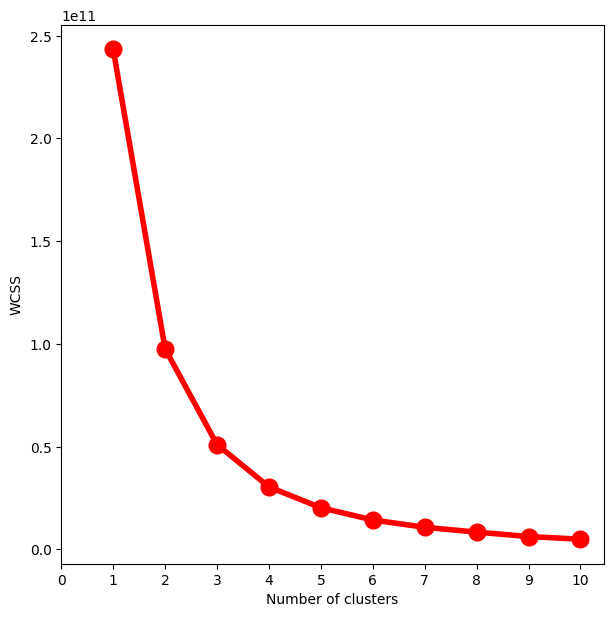

In [13]:
WCSS = []
for i in range(1,11):
    model = KMeans(n_clusters = i, init = 'k-means++')
    model.fit(x)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (7,7))
plt.plot(range(1,11),WCSS, linewidth=4, markersize=12,marker='o',color = 'red')
plt.xticks(np.arange(11))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [28]:
model = KMeans(n_clusters = 4, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_clusters = model.fit_predict(x)

In [58]:
model = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=50)
y_clusters = model.fit_predict(x)
unique_clusters, unique_cluster_counts = np.unique(y_clusters, return_counts=True)
count_pairs = np.asarray((unique_clusters, unique_cluster_counts)).T
count_pairs = count_pairs[np.argsort(-count_pairs[:, 1])]
print(count_pairs[:10])

[[   -1 19498]
 [ 3127  6203]
 [ 3128  5211]
 [ 3168  4874]
 [ 2896  4798]
 [ 3246  4615]
 [ 3242  4523]
 [ 3200  3774]
 [ 3189  3696]
 [ 2911  3396]]


3D Scatterplot of the clusters

<ipython-input-71-3fa07683765a>:5: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



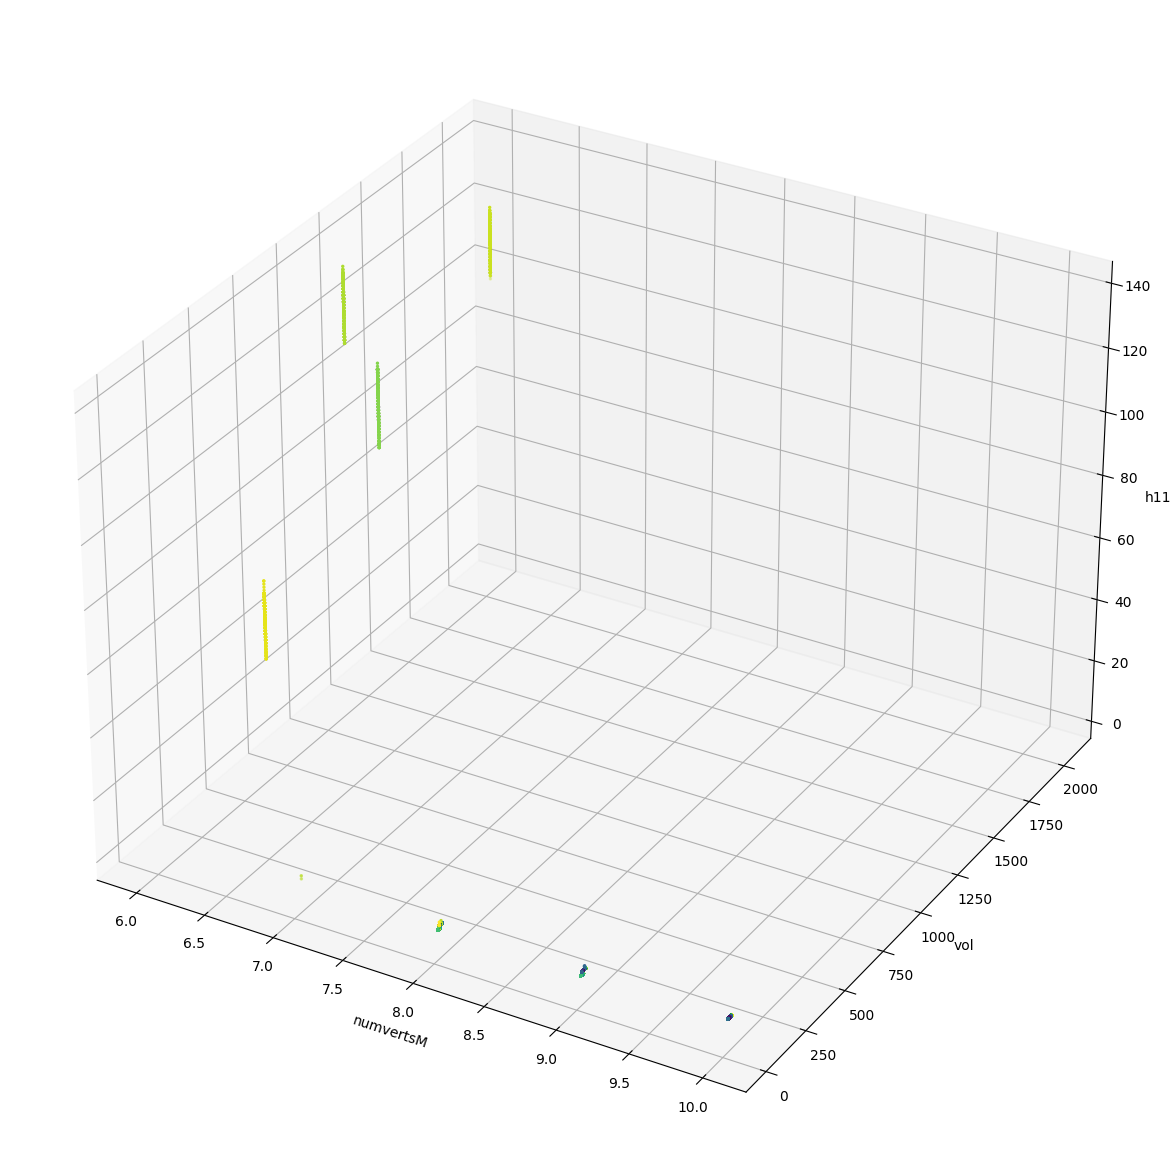

In [71]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')

num_colors = 50
colormap = cm.get_cmap('viridis', num_colors)

# use i+1 to start with 1 (omitting cluster value -1)
for i in range(0, num_colors):
  ax.scatter(x[y_clusters == count_pairs[i+1,0], 0],
             x[y_clusters == count_pairs[i+1,0], 1],
             x[y_clusters == count_pairs[i+1,0], 2],
             s = 2,
             color = colormap(i),
             label = "cluster {0}".format(i))

ax.set_xlabel(cluster_cols[0])
ax.set_ylabel(cluster_cols[1])
ax.set_zlabel(cluster_cols[2])
#ax.legend()
plt.show()

In [74]:
import plotly.graph_objs as go
import plotly.express as px
from plotly import tools
from plotly.subplots import make_subplots

fig = go.Figure()

Scene = dict(
    xaxis = dict(title = cluster_cols[0]),
    yaxis = dict(title = cluster_cols[1]),
    zaxis = dict(title = cluster_cols[2]))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = model.labels_

num_colors = 50
colormap = px.colors.sequential.Viridis
colors = px.colors.sample_colorscale(colormap, [i / num_colors for i in range(num_colors)])

for i in range(0, num_colors):
    fig.add_trace(go.Scatter3d(
        x=x[y_clusters == count_pairs[i+1,0], 0],
        y=x[y_clusters == count_pairs[i+1,0], 1],
        z=x[y_clusters == count_pairs[i+1,0], 2],
        mode='markers',
        marker=dict(color=colors[i % num_colors], size=2, line=dict(width=0)),
        name="cluster {0}".format(i),
        showlegend=False
    ))

# Set up the layout
fig.update_layout(
    margin = dict(l = 0, r = 0),
    scene=Scene,
    height=800,
    width=800,
    legend_title_text='Clusters'
)

fig.show()